# Анализ АB-теста

In [54]:
import pandas as pd
import pandahouse as ph
import random
import numpy as np
from scipy.stats import ttest_ind
from scipy import stats as st
import seaborn as sns
from matplotlib import pyplot as plt

In [55]:
#подключаюсь к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [3]:
# выгружаю данные по группам за необходимый период
query = """
    SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20230120.feed_actions 
WHERE toDate(time) between '2023-01-01' and '2023-01-07'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(query, connection=connection)

In [4]:
# средние значения ctr в двух группах примерно одинаковые
df[df['exp_group'] == 1].ctr.mean(), df[df['exp_group'] == 2].ctr.mean()

(0.21560459841296287, 0.21441927347479375)

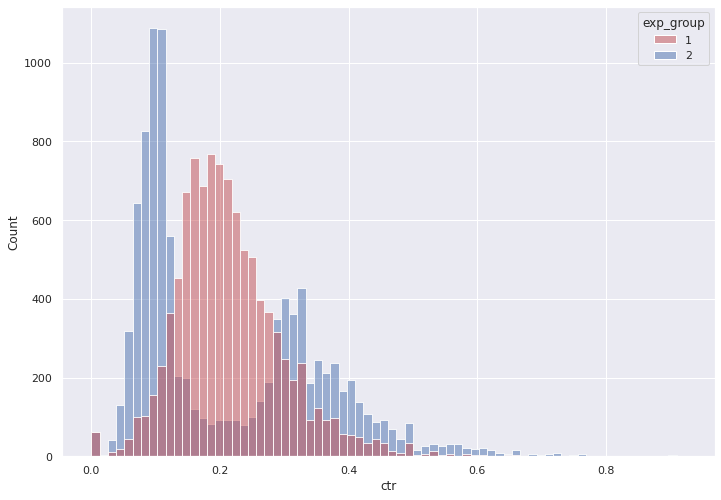

In [5]:
# для увеличения размера графиков
sns.set(rc={'figure.figsize':(11.7,8.27)})
# распределене CTR в группах 1 и 2 отличаются
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

#### Вывод: из графиков видно, что распределение ctr в первой группе больше похоже на нормальное. Во второй группе распределение скошено вправо и имеет «хвост» в правой части распределения, также отмечаются выбросы

## Тест Стьюдента

H0: новый алгоритм не приводит к увеличению CTR

H1: новый алгоритм приводит к увеличению CTR во второй группе

Уровень значимости установим равным α=0.05.

In [6]:
# проведем t тест
st.ttest_ind(df[df.exp_group == 1]['ctr'], df[df.exp_group == 2]['ctr'])

Ttest_indResult(statistic=0.7116545895251319, pvalue=0.4766869824114077)

##### p-value по результатам t теста больше уровня значимости 0,05. таким образом нельзя отклонить нулевую гипотезу о равенстве распределений тестовой и контрольной групп и утверждать, что CTR экспериментальной выборки не изменился.

##### Это связано с равенством средних значений CTR тестовой и контрольной групп, что заставляет t-тест ошибочно считать эти распределения похожими.

## Тест Манна Уитни

In [7]:
# проведем тест Манна-Уитни.
st.mannwhitneyu(df[df.exp_group == 1]['ctr'], df[df.exp_group == 2]['ctr'], alternative='two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

In [8]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

В 56.66 % случаев A > B. Должно получиться около 50%


##### p-value согласно тесту Манна Уитни значительно меньше уровня значимости 0,05.Можем отклонить нулевую гипотезу о равенстве распределений тестовой и контрольной группы.
##### + проведенный тест подтверждает график распределений
##### причина: в тесте Манна Уитни средние значения ctr не влияют на расчет p value

## Сглаженный CTR

In [9]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

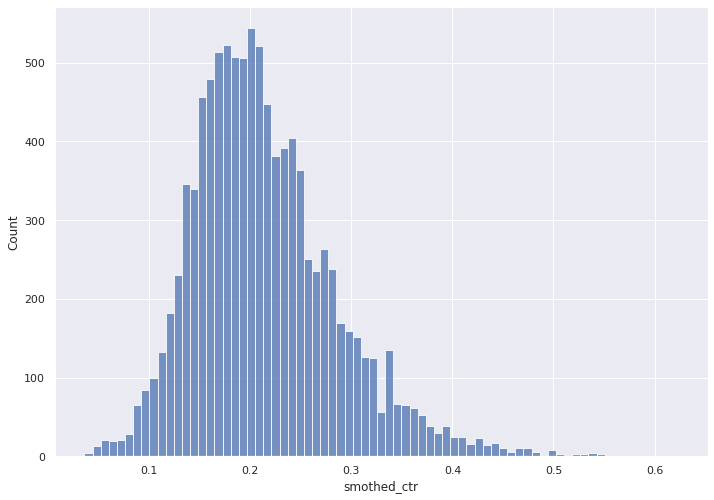

In [21]:
# расчет глобального ctr
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()


group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

# сглаженный CTR для контрольной группы с гиперпараметром α=5
# отразим график распределения полученной величины
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.histplot(group1.smothed_ctr, 
             kde = False)

<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

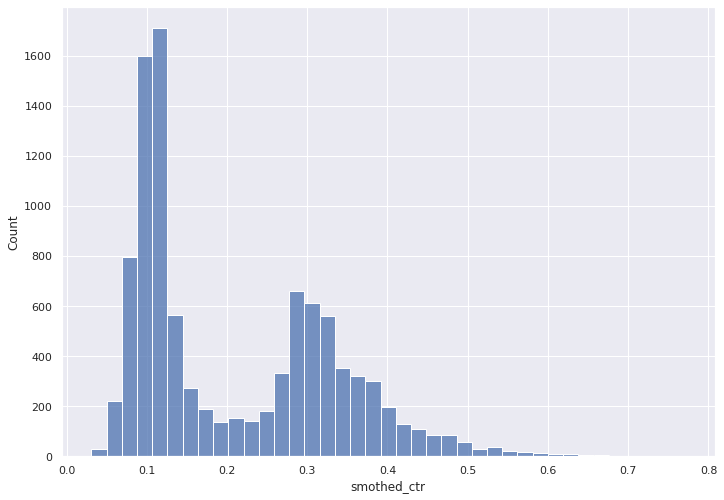

In [40]:
# сглаженный CTR для тестовой группы с гиперпараметром α=5
# отразим график распределения полученной величины

group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.histplot(group2.smothed_ctr, 
             kde = False)

In [45]:
# Проведём сравнение сглаженных CTR обеих групп t-тестом.
st.ttest_ind(group1.smothed_ctr, group2.smothed_ctr, equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

##### По результатам t теста на сглаженном CTR p-value меньше уровня значимости 0,05. Можем отклонить нулевую гипотезу о равенстве двух групп.
##### Сглаживание позволило избавиться от шума (пользователи с небольшим количеством просмотров).
##### Однако проблема сглаженного CTR состоит в том, что нет гарантии, что его направленность совпадает с направленностью общего количества кликов.

## Пуассоновский бутстреп

In [12]:
 # функция для бутстрепа
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = st.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = st.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<AxesSubplot:ylabel='Count'>

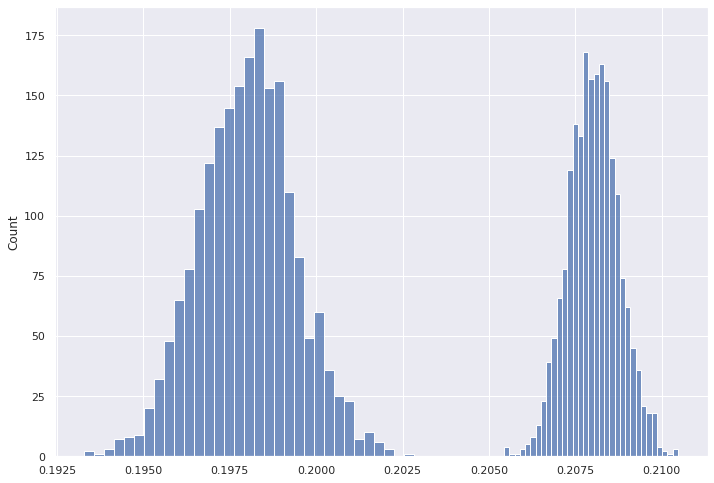

In [13]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

In [14]:
st.ttest_ind(ctr1, ctr2, equal_var = False)

Ttest_indResult(statistic=285.9937856776152, pvalue=0.0)

In [15]:
print(ctr1.mean(), ctr2.mean())

0.20802577152676782 0.19799085723417026


##### Согласно графику распределения двух групп не пересекаются. Нулевая гипотеза может быть опровергнута. 
##### Значение CTR тестовой группы снижается относительно контрольной группы
##### Вывод который предварительно можно сделать относительно раскатывания обновление на всех пользователей: 
##### лучше этого делать не нужно, чтобы не ухудшить метрику CTR

## Бакетное преобразование

In [57]:
q = """
    SELECT exp_group, bucket,
    SUM(likes)/SUM(views) as bucket_ctr
    FROM(SELECT exp_group, xxHash64(user_id)%50 as bucket,
            user_id,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes/views as ctr
            FROM simulator_20230120.feed_actions
            WHERE (toDate(time) >= '2023-01-01' AND toDate(time) <= '2023-01-07')
            AND (exp_group = 2 OR exp_group = 1)            
            GROUP BY exp_group, bucket, user_id)
    GROUP BY exp_group, bucket"""
df1 = ph.read_clickhouse(q, connection=connection)
display(df1.head())

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


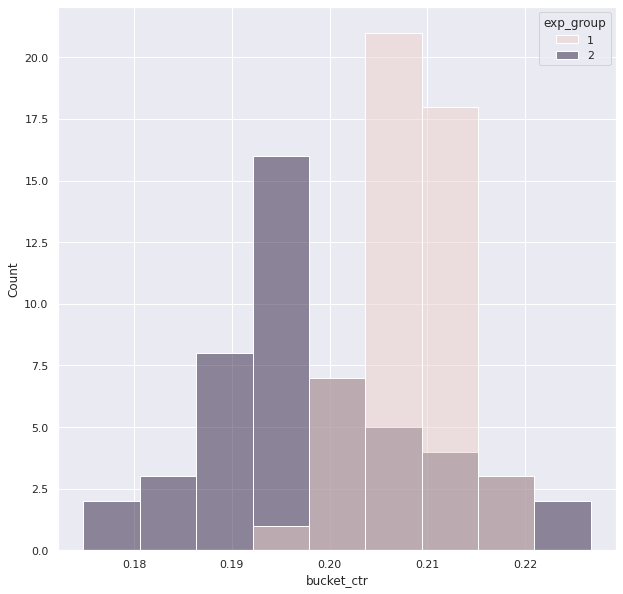

In [62]:
# Распределение CTR пользовательских бакетов для обеих групп.
fig, ax = plt.subplots(1, figsize=(10,10))
sns.histplot(data=df1, x='bucket_ctr', hue='exp_group')
plt.show()

In [64]:
#проверим, схожи ли наши выборки
print('p-value для Манн_Уитни:',st.mannwhitneyu(df1[df1.exp_group == 1].bucket_ctr, 
                   df1[df1.exp_group == 2].bucket_ctr).pvalue)

p-value для Манн_Уитни: 2.859963936492646e-07


In [66]:
# Проведем t тест
st.ttest_ind(df1[df1.exp_group == 1].bucket_ctr, 
                   df1[df1.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

##### Проведенный А|Б тест показал, что тестовая и контрольная группа различаются
##### При этом у тестовой группы средний показатель CTR ниже, чем у контрольной группы. 
##### Однако некоторым пользователям тестовой группы новый алгорим рекомендаций вероятнее всего понравился - 
##### об этом свидетельтвует второй пик на графике распределения CTR

##### Окончательно рекомендацией было бы не раскатывать обновление на все пользователей, а потестировать работу алгоритма рекомендаций